## LIBRARY

In [9]:
import numpy as np
import matplotlib.pyplot as np
import seaborn as sns
import pandas as pd 

In [10]:
climate = pd.read_csv("climate_data.csv")
climate.columns = ["Station", "Year", "Month", "Day", "MaxTemp", "MinTemp", "Rainfall"]
visitor = pd.read_csv("visitor.csv")

# climate['date'] = pd.to_datetime(climate[['year', 'month', 'day']])


In [11]:
import pandas as pd
from datetime import datetime, timedelta

# Step 1: Create datetime column
climate['Date'] = pd.to_datetime(climate[['Year', 'Month', 'Day']])

# Step 2: Define weekly start dates (only need day and month)
week_starts = pd.to_datetime([
    "06-09", "06-16", "06-23", "06-30",
    "07-07", "07-14", "07-21", "07-28",
    "08-04", "08-11", "08-18", "08-25",
    "09-01", "09-08", "09-15"
], format='%m-%d')

# Step 3: Generate full list of week ranges (per year in data)
week_ranges = []

for year in climate['Year'].unique():
    for i, week_start in enumerate(week_starts):
        start = datetime(year, week_start.month, week_start.day)
        end = start + timedelta(days=6)
        week_ranges.append((start, end, i+1))

# Step 4: Assign weeks
def get_week(date):
    for start, end, week_name in week_ranges:
        if start <= date <= end:
            return week_name
    return None

climate['Week'] = climate['Date'].apply(get_week)

# Step 5: Keep only rows with a valid week assignment
climate_filtered = climate[climate['Week'].notna()].copy()


In [12]:
# keep only the relevant date
climate_filtered = climate_filtered[
    climate_filtered['Year'].between(2014, 2024)
].copy()

In [13]:
climate_filtered.columns

Index(['Station', 'Year', 'Month', 'Day', 'MaxTemp', 'MinTemp', 'Rainfall',
       'Date', 'Week'],
      dtype='object')

In [14]:
weekly_climate = climate_filtered.groupby(['Station','Year', 'Week']).agg({
    'MaxTemp': 'mean',
    'MinTemp': 'mean',
    'Rainfall': 'sum'
}).reset_index()
weekly_climate

,Station,Year,Week,MaxTemp,MinTemp,Rainfall
0,71032,2014,1.0,4.714286,-2.000000,40.6
1,71032,2014,2.0,2.657143,-1.685714,8.0
2,71032,2014,3.0,-1.028571,-4.114286,4.2
3,71032,2014,4.0,-1.314286,-4.357143,0.4
4,71032,2014,5.0,-1.685714,-5.185714,3.0
...,...,...,...,...,...,...
1150,85291,2024,11.0,6.157143,1.650000,26.2
1151,85291,2024,12.0,5.428571,0.928571,23.6
1152,85291,2024,13.0,7.142857,-0.100000,50.6
1153,85291,2024,14.0,5.628571,-0.116667,45.8


In [15]:
climate_filtered.to_csv("climate_filtered.csv", index=False)

In [16]:
visitor_long = pd.melt(
    visitor,
    id_vars=['Year', 'Week'],            # columns to keep fixed
    var_name='Resort',                   # name for the new column that holds resort names
    value_name='Visitors'               # name for the new column that holds visitor numbers
)
visitor_long

,Year,Week,Resort,Visitors
0,2014,1,Mt. Baw Baw,555
1,2014,2,Mt. Baw Baw,804
2,2014,3,Mt. Baw Baw,993
3,2014,4,Mt. Baw Baw,2976
4,2014,5,Mt. Baw Baw,11112
...,...,...,...,...
1480,2024,11,Charlotte Pass,2667
1481,2024,12,Charlotte Pass,2392
1482,2024,13,Charlotte Pass,1323
1483,2024,14,Charlotte Pass,454


In [17]:
resort_to_station_id = {
    "Mt. Baw Baw": "85291",
    "Mt. Stirling": "83024",                 # Uses Mount Buller's station
    "Mt. Hotham": "83085",
    "Falls Creek": "83084",
    "Mt. Buller": "83024",
    "Selwyn": "72161",                       # Cabramurra SMHEA AWS
    "Thredbo": "71032",                      # Thredbo AWS
    "Perisher": "71075",                     # Perisher AWS   
}

visitors_main = visitor_long[visitor_long["Resort"] != "Charlotte Pass"].copy()

# Assign station ID
visitors_main["Station"] = visitors_main["Resort"].map(resort_to_station_id)
visitors_main

,Year,Week,Resort,Visitors,Station
0,2014,1,Mt. Baw Baw,555,85291
1,2014,2,Mt. Baw Baw,804,85291
2,2014,3,Mt. Baw Baw,993,85291
3,2014,4,Mt. Baw Baw,2976,85291
4,2014,5,Mt. Baw Baw,11112,85291
...,...,...,...,...,...
1315,2024,11,Perisher,49136,71075
1316,2024,12,Perisher,43382,71075
1317,2024,13,Perisher,23908,71075
1318,2024,14,Perisher,8244,71075


In [18]:
visitors_main["Station"] = visitors_main["Station"].astype(str)
weekly_climate["Station"] = weekly_climate["Station"].astype(str)

visitors_main["Year"] = visitors_main["Year"].astype(int)
weekly_climate["Year"] = weekly_climate["Year"].astype(int)

visitors_main["Week"] = visitors_main["Week"].astype(int)
weekly_climate["Week"] = weekly_climate["Week"].astype(int)

# Now merge with matching column names
merged_main = visitors_main.merge(
    weekly_climate,
    left_on=["Year", "Week", "Station"],
    right_on=["Year", "Week", "Station"],
    how="left",
)

In [19]:
# Filter climate data for the two stations
cp_climate = weekly_climate[weekly_climate["Station"].isin(["71032", "71075"])]

# Group by year and week, take mean of climate variables
cp_avg = cp_climate.groupby(["Year", "Week"], as_index=False).agg({
    "MaxTemp": "mean",
    "MinTemp": "mean",
    "Rainfall": "mean"  # or sum if that's more appropriate
})
# Add Charlotte Pass metadata
cp_avg["Resort"] = "Charlotte Pass"

# Pull in visitor data for Charlotte Pass
charlotte_visitors = visitor_long[visitor_long["Resort"] == "Charlotte Pass"][["Year", "Week", "Visitors"]]

# Merge to assign visitor numbers
cp_merged = cp_avg.merge(charlotte_visitors, on=["Year", "Week"], how="left")
cp_merged.head(5)


,Year,Week,MaxTemp,MinTemp,Rainfall,Resort,Visitors
0,2014,1,5.521429,-1.792857,51.3,Charlotte Pass,408
1,2014,2,3.957143,-1.771429,10.9,Charlotte Pass,151
2,2014,3,-0.071429,-3.285714,112.4,Charlotte Pass,230
3,2014,4,0.814286,-3.407143,27.1,Charlotte Pass,1134
4,2014,5,-0.250000,-4.471429,21.0,Charlotte Pass,3403


In [20]:
# Concatenate Charlotte Pass with the rest
final_merged = pd.concat([merged_main, cp_merged], ignore_index=True)
df = final_merged.drop(columns=["Station"])

In [21]:
# df.to_csv("climate_visitor.csv", index=False)

In [22]:
df["Resort"].unique()

array(['Mt. Baw Baw', 'Mt. Stirling', 'Mt. Hotham', 'Falls Creek',
       'Mt. Buller', 'Selwyn', 'Thredbo', 'Perisher', 'Charlotte Pass'],
      dtype=object)

In [23]:
df.columns

Index(['Year', 'Week', 'Resort', 'Visitors', 'MaxTemp', 'MinTemp', 'Rainfall'], dtype='object')

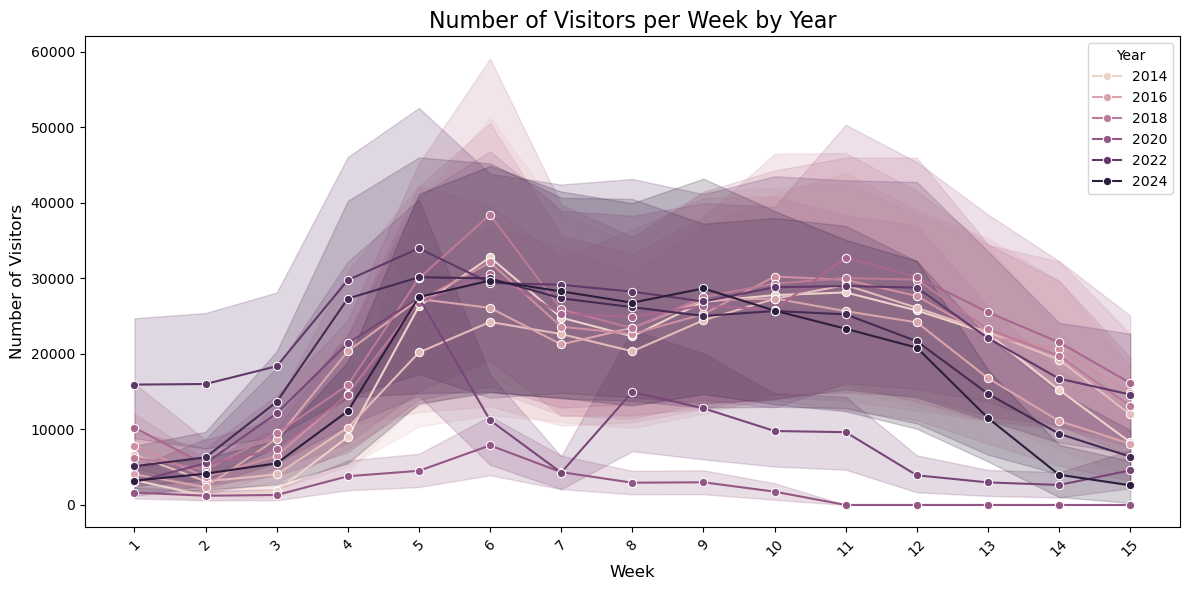

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame `weekly_summary`
# First, ensure your 'Week' is treated as a categorical variable for better visualization
df['Week'] = df['Week'].astype(str)

# Create a seaborn line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Week', y='Visitors', hue='Year', marker='o')

# Add labels and title
plt.title('Number of Visitors per Week by Year', fontsize=16)
plt.xlabel('Week', fontsize=12)
plt.ylabel('Number of Visitors', fontsize=12)
plt.xticks(rotation=45)  # Rotate week labels for clarity


# Display the plot
plt.tight_layout()
plt.show()
